In [1]:
import pandas as pd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = "https://github.com/danielbanafshei01/MN5813/raw/main/online_retail.csv.zip"

zipfile = zipfile.ZipFile(io.BytesIO(requests.get(url).content))
df = pd.read_csv(zipfile.open
                 (zipfile.namelist()[0]))

df.head()
#The data set of customer preference is loaded in and the first 5 rows are displayed


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isnull().any()
# Displays the columns in our data set and to check if there are any NAN values in any columns 


InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [4]:
print('Number of duplicated data:')
df.duplicated().sum()
#Checks for duplicated data and returns how many duplicates there are

Number of duplicated data:


5268

In [5]:
df['Description']=df['Description'].fillna('Product Unknown')
df['CustomerID']= df['CustomerID'].fillna(0)
#Nan values in categories have been replaced with placeholders
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce').dt.date
#time of invoice date removed
df['Revenue']=df['Quantity']*df['UnitPrice']
#added revenue to data frame

In [6]:
df.loc[df['StockCode'] == '85123A', 'Description'].unique()


array(['WHITE HANGING HEART T-LIGHT HOLDER', '?',
       'wrongly marked carton 22804',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

Descriptions are messy, the next logical step to clean description is by matching it with the most frequent stock code 

In [7]:
sorted_descriptions = (
    df.groupby(['StockCode', 'Description'])
      .size()
      .reset_index(name='count')
      .sort_values(['StockCode', 'count'], ascending=[True, False])
      .drop_duplicates(subset=['StockCode'])
      .set_index('StockCode')['Description']
)

df['Description'] = df['StockCode'].map(
    sorted_descriptions.to_dict())






In [8]:
df.loc[df['StockCode'] == '85123A', 'Description'].unique()
#check to see if code worked

array(['WHITE HANGING HEART T-LIGHT HOLDER'], dtype=object)

In [9]:
df=df.drop_duplicates()
#duplicates are dropped 

In [10]:
# View all unique countries in the data set
print(df['Country'].unique())



['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


There are two categories in country which are: unspecified and European community. The best case situation is to combine these countries into an 'other' category as dropping them may skew the data 

In [11]:
df['Country']= df['Country'].replace({
    'Unspecified': 'Other',
    'European Community': 'Other'
})
#combined the categories into 'Other'
df['Country']=df['Country'].replace('EIRE','Ireland')
#replace the country code of EIRE to correct country name of Ireland

In [12]:

top_sold = (
    df['StockCode']
        .value_counts()
        .reset_index(name='Amount')
        .rename(columns = {'index': ['StockCode']})
    .head(10)
)
#This shows the top 10 most sold products by individual transaction 
top_sold['Description']=top_sold['StockCode'].map(sorted_descriptions)
top_sold

,StockCode,Amount,Description
0,85123A,2301,WHITE HANGING HEART T-LIGHT HOLDER
1,22423,2192,REGENCY CAKESTAND 3 TIER
2,85099B,2156,JUMBO BAG RED RETROSPOT
3,47566,1720,PARTY BUNTING
4,20725,1626,LUNCH BAG RED RETROSPOT
5,84879,1489,ASSORTED COLOUR BIRD ORNAMENT
6,22720,1469,SET OF 3 CAKE TINS PANTRY DESIGN
7,22197,1468,POPCORN HOLDER
8,21212,1367,PACK OF 72 RETROSPOT CAKE CASES
9,22383,1328,LUNCH BAG SUKI DESIGN


In [13]:
most_sold = (
    df.groupby('StockCode', as_index=False)
      .agg(Quantity=('Quantity', 'sum'))
      .sort_values('Quantity', ascending=False)
    .head(10)
      
)
#this shows the top 10 most sold products by quantity
most_sold['Description']=most_sold['StockCode'].map(sorted_descriptions)
most_sold

,StockCode,Quantity,Description
1147,22197,56427,POPCORN HOLDER
2997,84077,53751,WORLD WAR 2 GLIDERS ASSTD DESIGNS
3515,85099B,47260,JUMBO BAG RED RETROSPOT
3536,85123A,38811,WHITE HANGING HEART T-LIGHT HOLDER
3305,84879,36122,ASSORTED COLOUR BIRD ORNAMENT
454,21212,36016,PACK OF 72 RETROSPOT CAKE CASES
1982,23084,30597,RABBIT NIGHT LIGHT
1412,22492,26437,MINI PAINT SET VINTAGE
1530,22616,26299,PACK OF 12 LONDON TISSUES
966,21977,24719,PACK OF 60 PINK PAISLEY CAKE CASES


In [14]:
comparison_sold = most_sold.merge(
    top_sold[['StockCode', 'Amount']],
)
comparison_sold

,StockCode,Quantity,Description,Amount
0,22197,56427,POPCORN HOLDER,1468
1,85099B,47260,JUMBO BAG RED RETROSPOT,2156
2,85123A,38811,WHITE HANGING HEART T-LIGHT HOLDER,2301
3,84879,36122,ASSORTED COLOUR BIRD ORNAMENT,1489
4,21212,36016,PACK OF 72 RETROSPOT CAKE CASES,1367


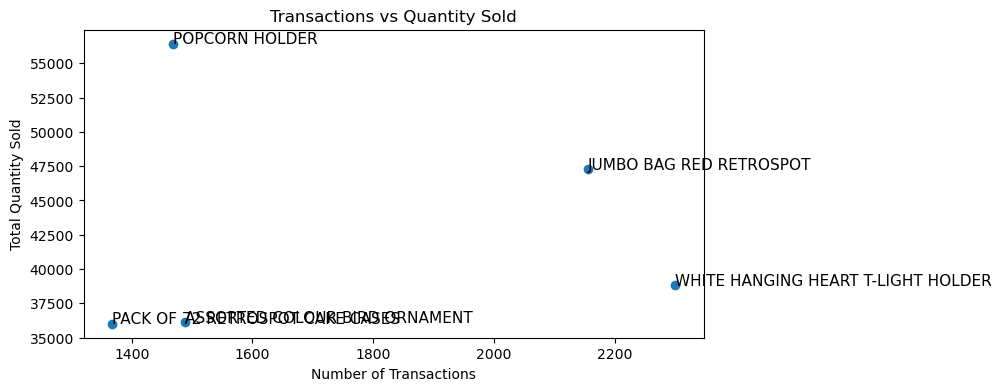

In [15]:
plt.figure(figsize=(8,4)) 
plt.scatter(comparison_sold['Amount'], comparison_sold['Quantity']) 
for i, row in comparison_sold.iterrows(): 
    plt.text(row['Amount'], row['Quantity'], row['Description'], fontsize=11) 

plt.xlabel('Number of Transactions') 
plt.ylabel('Total Quantity Sold') 
plt.title('Transactions vs Quantity Sold') 
plt.show()


Based on this visual, the company need to focus on 2 main products: popcorn holders and white hanging heart t-light holders. 

Popcorn holders are the most sold product yet there is fewer than 1500 transactions meaning that the product needs to be advertised more thoroughly to increase visibility which will allow the product to increase the number of transactions. 

White hanging heart t-light holders are the opposite where number of transactions surplus the amount of this item sold. This item needs to sold in bulks using promotional deals to increase the amount of this item sold. 

In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].dt.year.min(), df['InvoiceDate'].dt.year.max()
#from which years our data ranges from


(2010, 2011)

In [17]:
df.groupby(df['InvoiceDate'].dt.year)['InvoiceDate'].apply(lambda x: x.dt.month.unique())



InvoiceDate
2010                                       [12]
2011    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Name: InvoiceDate, dtype: object

Analysis between two years is not possible as months of January to November of 2010 are not shown in the data set. Only months of December can be used for comparisons between the two years in which we will dive deeply and analyse any noticeable changes. We will be looking mostly at the changes in revenue over the year of 2011.  

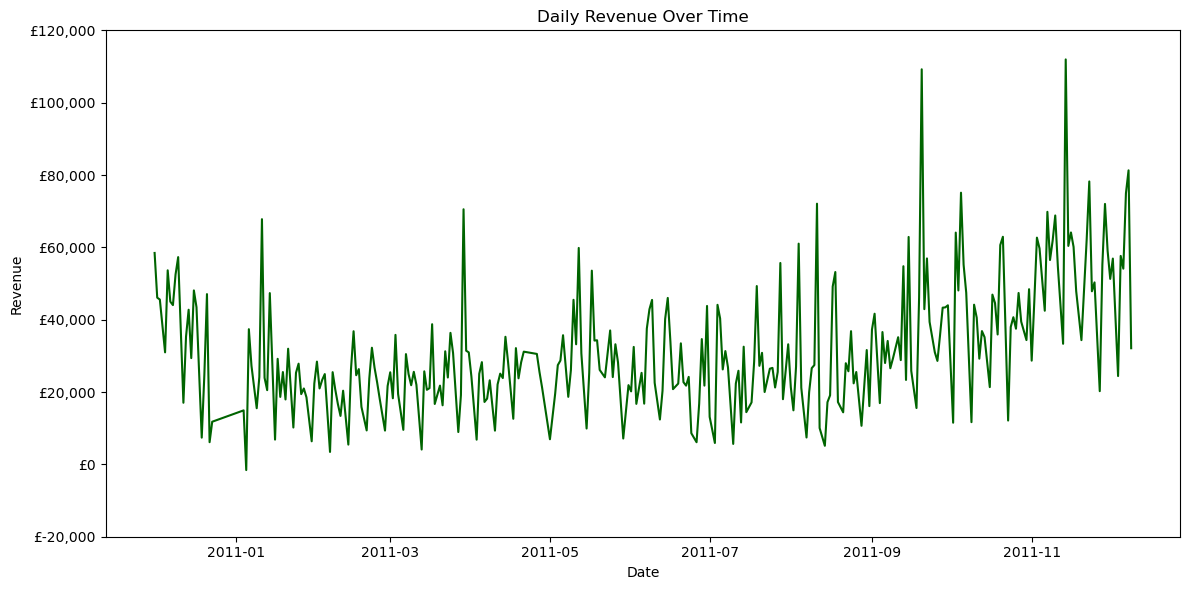

In [18]:
daily_revenue = (
      df.groupby(df['InvoiceDate'].dt.date)
      .agg(Daily_Revenue=('Revenue', 'sum'))
      .reset_index()
)
daily_revenue.columns = ['Date', 'Daily_Revenue']

plt.figure(figsize=(12,6))
plt.plot(daily_revenue['Date'], daily_revenue['Daily_Revenue'], color= 'darkgreen')
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
yticks = plt.yticks()[0]
formatted_yticks = [f"£{int(y):,}" for y in yticks]
plt.yticks(yticks, formatted_yticks)
plt.tight_layout()
plt.show()

This chart shows the daily revenue over time in the data set and how it changes. There are many fluctuations over time with high peaks and dips, where some days there are negative revenue in particular the start of January of 2011. This can be possibly due to returns,refunds or wastage. Generally there is an upward trend in revenue especially during months of October to December of 2011 with revenues exceeding £100,000.  

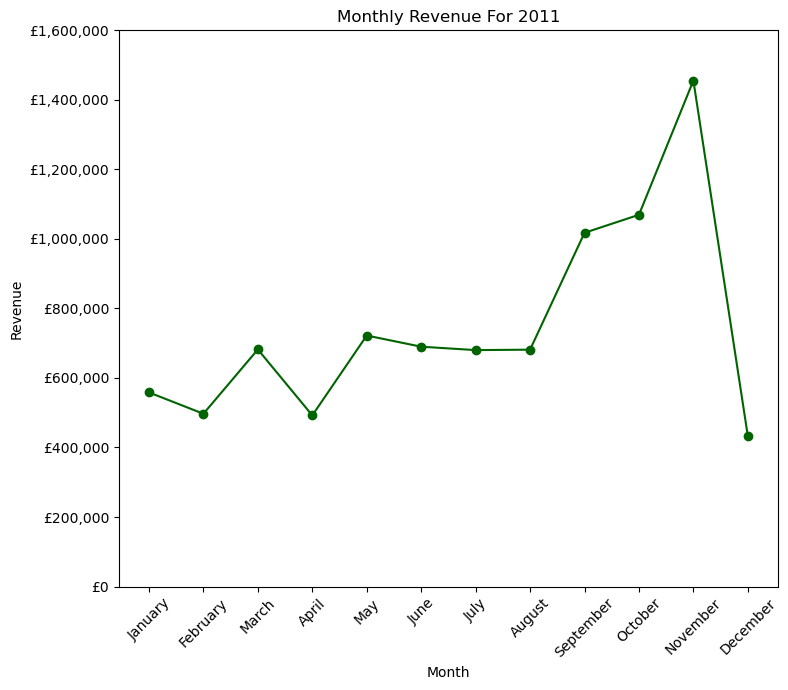

In [19]:
monthly_revenue = (
    df.assign(
        Year=df['InvoiceDate'].dt.year,
        Month=df['InvoiceDate'].dt.month,
    
    )
    .groupby(['Year', 'Month'])
    .agg(Monthly_Revenue=('Revenue', 'sum'))
    .reset_index()
)

monthly_revenue = monthly_revenue.sort_values(['Year', 'Month'])
monthly_revenue['Month'] = pd.to_datetime(
    monthly_revenue['Month'], format='%m'
).dt.strftime('%B')

monthly_revenue_2011= monthly_revenue.query('Year != 2010')

plt.figure(figsize=(8,7))

plt.plot(
    monthly_revenue_2011['Month'],
    monthly_revenue_2011['Monthly_Revenue'],
    marker='o',
    color='darkgreen'
)

plt.title('Monthly Revenue For 2011')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.ylim(0)

yticks = plt.yticks()[0]
formatted_yticks = [f"£{int(y):,}" for y in yticks]
plt.yticks(yticks, formatted_yticks)

plt.tight_layout()
plt.show()

Monthly revenue trend analysis is important to carry out to identify how the company performed over the year and to see which months have particularly struggled. Overall, the monthly trend for the year of 2011 is positive as most months produce a revenue of over £500,000. We see there is a sharp decline in sales in the month in December so we will now investigate what caused this.

In [20]:
monthly_revenue['Monthly_Revenue'] = (
    monthly_revenue['Monthly_Revenue'].map(lambda x: f"£{x:,.2f}"))

monthly_revenue


,Year,Month,Monthly_Revenue
0,2010,December,"£746,723.61"
1,2011,January,"£558,448.56"
2,2011,February,"£497,026.41"
3,2011,March,"£682,013.98"
4,2011,April,"£492,367.84"
5,2011,May,"£722,079.25"
6,2011,June,"£689,977.23"
7,2011,July,"£680,156.99"
8,2011,August,"£681,386.46"
9,2011,September,"£1,017,592.78"


In [21]:
orders_by_country = (
    df.groupby('Country')['InvoiceNo']
      .nunique()
      .reset_index(name='Number of Orders')
      .sort_values('Number of Orders', ascending=False)

)
total_revenue_by_country=(
    df.groupby('Country')['Revenue'].sum()
)
customer_country=(
    df.groupby('Country')['CustomerID']
    .nunique()
    .reset_index()
    .rename(columns={'CustomerID':'Customers'})
    .sort_values('Customers',ascending=False)
)
country_comparison = orders_by_country.merge(
    total_revenue_by_country,
    on='Country'
)
country_comparison=country_comparison.merge(
    customer_country,
    on='Country',

)
country_comparison['Average Order Value'] = (country_comparison['Revenue'] / 
                                             country_comparison['Number of Orders']
                                            )


country_comparison.head(10)




,Country,Number of Orders,Revenue,Customers,Average Order Value
0,United Kingdom,23494,8166572.434,3951,347.602470
1,Germany,603,221509.470,95,367.345721
2,France,461,197317.110,88,428.019761
3,Ireland,360,262993.380,4,730.537167
4,Belgium,119,40910.960,25,343.789580
5,Spain,105,54756.030,31,521.486000
6,Netherlands,101,284661.540,9,2818.431089
7,Switzerland,74,56363.050,22,761.662838
8,Portugal,71,29302.970,20,412.717887
9,Australia,69,137009.770,9,1985.648841


From this data it is clear to us that this company is based in the UK so a country analysis excluding UK is important to analyse. This is to identify which countries the company should prioritise with its exports.



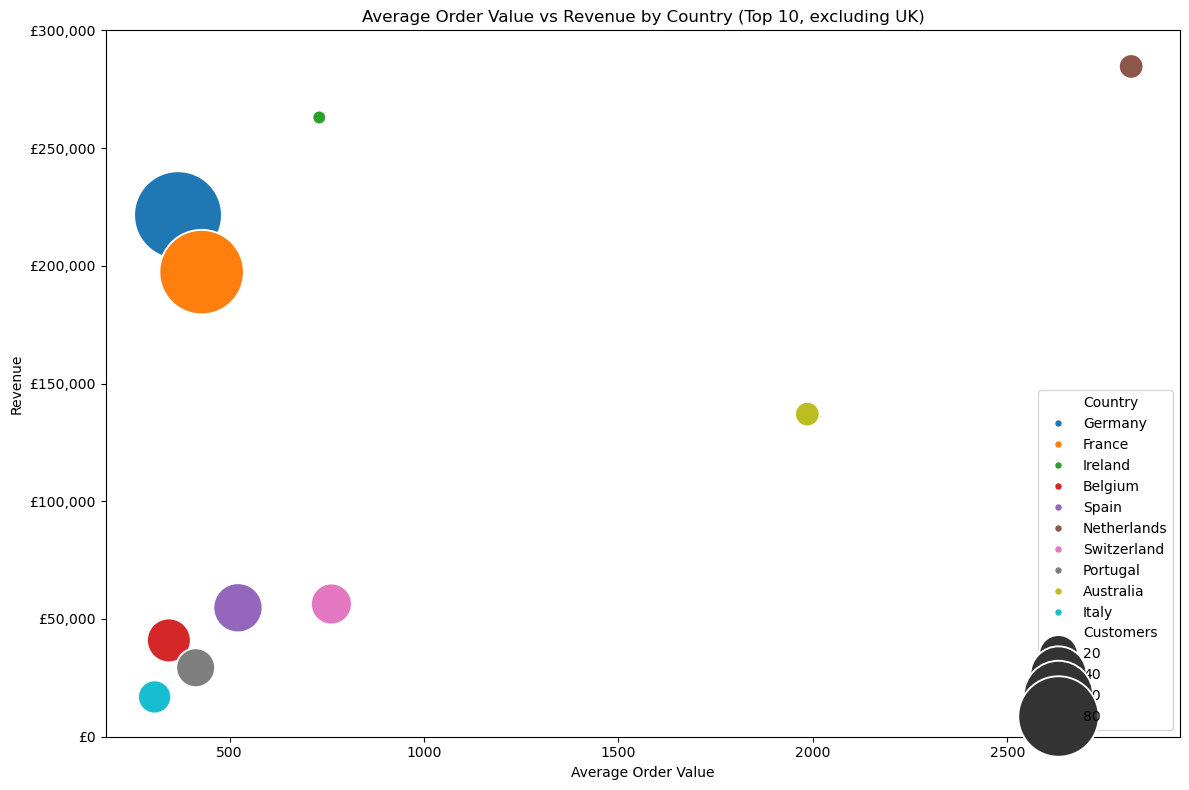

In [22]:
country_comparison_wouk=country_comparison.query("Country != 'United Kingdom'")
plt.figure(figsize=(12,8)) 
sns.scatterplot( data=country_comparison_wouk.head(10),
                 x='Average Order Value',
                 y='Revenue', 
                 hue='Country', 
                 size='Customers',
                 sizes=(100,4000),
                 alpha=1,
)

plt.title('Average Order Value vs Revenue by Country (Top 10, excluding UK)')
plt.xlabel('Average Order Value') 
plt.ylabel('Revenue') 
yticks = plt.yticks()[0] 
formatted_yticks = [f"£{int(y):,}" for y in yticks]
plt.yticks(yticks, formatted_yticks) 
plt.tight_layout() 
plt.show()

The size of each bubble represents the amount of unique customers per country. Generally speaking the bigger the bubble, the less the company has to rely on few customers. The company should focus its attentions to the highest revenue countries with highest order value such as Netherlands and Ireland . The priority should be to focus on expanding its customer base in these countries as these countries bring in the most revenue from very few customers. 


In [23]:
country_product= (
    df.groupby(['Country', 'Description'], as_index=False)
      .agg(Quantity=('Quantity', 'sum')
          ))

most_sold_product_by_country = (
    country_product
    .sort_values(['Country', 'Quantity'], ascending=[True, False])
    .groupby('Country')
    .head(1)
)

most_sold_product_by_country.head(5)

,Country,Description,Quantity
274,Australia,MINI PAINT SET VINTAGE,2916
843,Austria,SET 12 KIDS COLOUR CHALK STICKS,288
911,Bahrain,ICE CREAM SUNDAE LIP GLOSS,96
1335,Belgium,PACK OF 72 RETROSPOT CAKE CASES,480
1700,Brazil,DOLLY GIRL LUNCH BOX,24


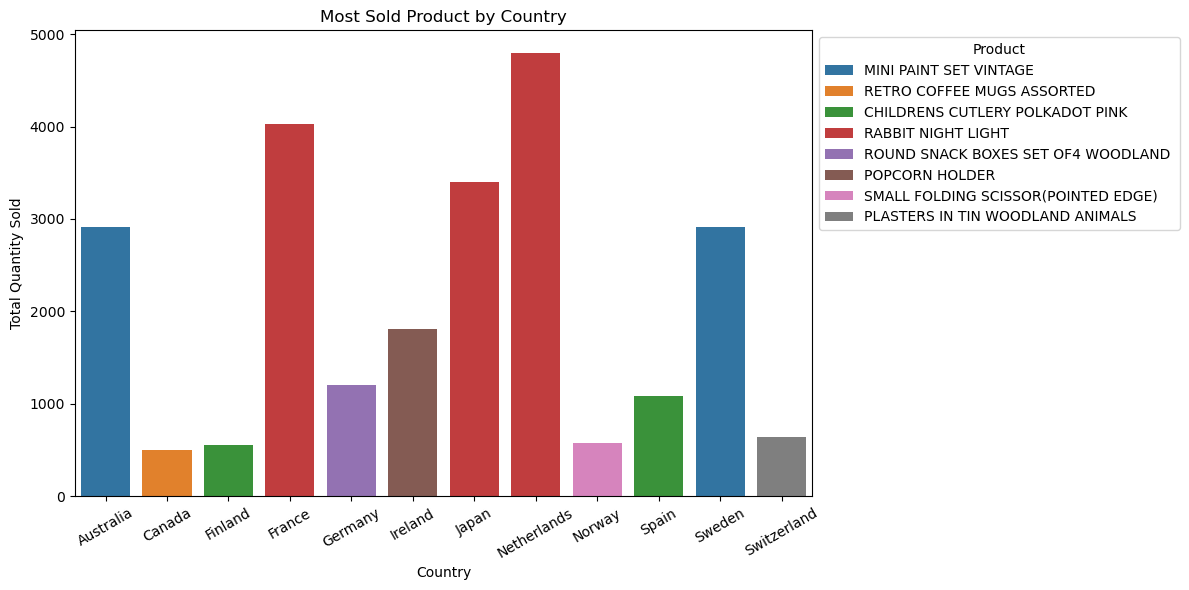

In [24]:
most_sold_product_by_country_filtered = (
    most_sold_product_by_country
    .query(" Country != 'United Kingdom' and Quantity > 500")
)


plt.figure(figsize=(12, 6))
sns.barplot(
    data=most_sold_product_by_country_filtered, 
    x='Country', 
    y='Quantity', 
    hue='Description',
   

)
plt.xticks(rotation=30)
plt.title('Most Sold Product by Country')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Country')

plt.tight_layout()
plt.show()


Products that are sold most in each country is very important to identify to manage inventory levels effectively and to understand consumer demand of each product. This insight can help the company reduce costs of inventory management through lowering shipping expenses and storage costs. The marketing department can be given this information which is vital for them to budget more effectively. Through this they are likely able to gain a higher ROI on advertisement which in turn can generate further sales of those specific products. For example, using this visual we can identify that the rabbit night light product are most popular in 3 different countries so the marketing team in essence can increase their spend on advertisement and promotions of this product in those specific countries which should lead to further sales.   


In [25]:
uk_df=df[df['Country']=='United Kingdom']
uk_df=uk_df = df.query("Country == 'United Kingdom' and CustomerID != 0")
customer_uk=(
    uk_df
    .groupby('CustomerID')['InvoiceNo']
    .nunique()
    .reset_index(name='Number of Orders Placed')
 
    
    
)
customer_uk.head(5)
#table for number of orders placed by UK customers
customer_uk['Customer Type'] = customer_uk['Number of Orders Placed'].apply(
    lambda x: 'New' if x < 5 else ('Loyal'if x>20 else 'Repeat')
)
customer_uk.head(5)

,CustomerID,Number of Orders Placed,Customer Type
0,12346.0,2,New
1,12747.0,11,Repeat
2,12748.0,224,Loyal
3,12749.0,8,Repeat
4,12820.0,4,New


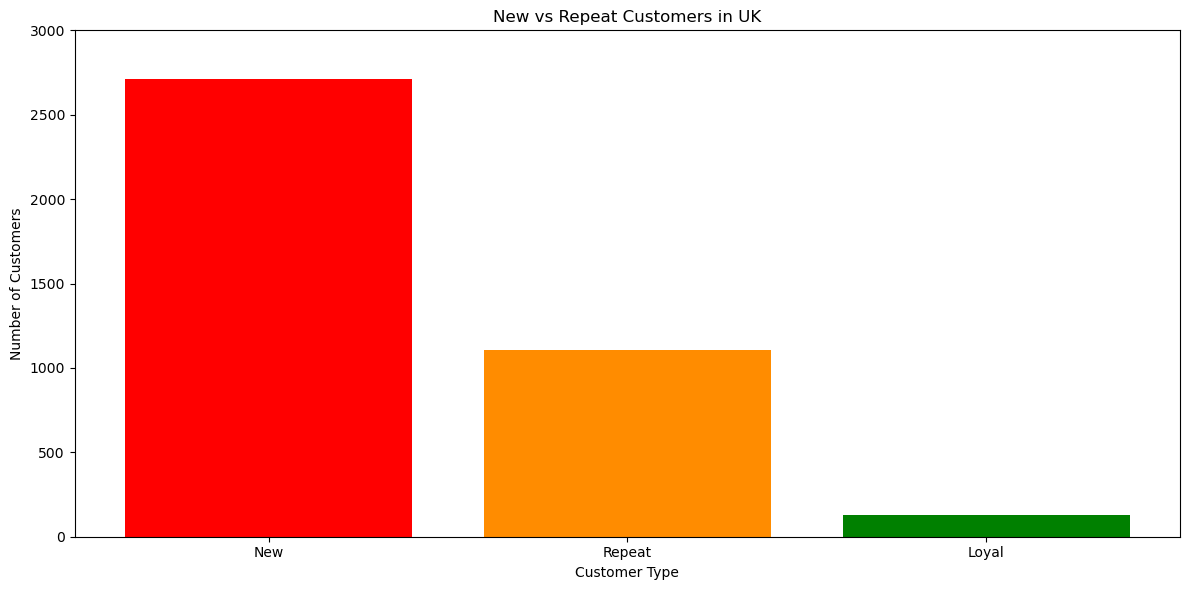

In [26]:
counts = customer_uk['Customer Type'].value_counts() 
plt.figure(figsize=(12,6))
bars = plt.bar(counts.index, counts.values, color=['red', 'darkorange','green'], width=0.8)  

plt.title('New vs Repeat Customers in UK')
plt.xlabel('Customer Type')
plt.ylabel('Number of Customers')
plt.ylim(0, 3000)
plt.tight_layout()
plt.show()




We assumed that if a customer has placed more than 5 orders in separate transactions they are likely to be a repeat customer and if they placed 20 orders they are loyal. From this data almost half of the customers for the company in the UK are repeat customers. Repeat customers are important as they maintain a steady revenue stream. Repeat and loyal customers have lower acquisition costs as it is cheaper to retain existing customers over new customers. Ideally, you want to transition customers step by step from new to repeat to loyal to maximise revenue. 

References: 

ulrikthygepedersen. (2022) Online Retail Dataset [dataset]. Kaggle. Available at: https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset 